In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_roc_curve

from prep_data import load_data, apply_pca


In [9]:
X, y = load_data()

In [10]:
cols = X.columns.str.contains('strengths|weakness|compared_to_others')
X_with_pca = apply_pca(X, cols, 0.75)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)


In [11]:
#####################
### BOOSTING TREE ###
#####################

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)

clf.score(X_train, y_train)

0.90963030579644

In [13]:
parameters = {
    'loss': ('log_loss', 'exponential'),
#     'learning_rate': np.arange(0.05, 0.31, 0.05),
    'subsample': np.arange(0.7, 1.01, 0.1),
    'n_estimators': np.arange(100, 1001, 100),
    'ccp_alpha': np.arange(0, 0.05, 0.01),
    'max_depth': np.arange(1, 6, 1),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
}

clf = GradientBoostingClassifier(random_state=0)
cv = RandomizedSearchCV(clf, parameters, n_iter=200, verbose=1, n_jobs=-1, scoring='roc_auc')
cv.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04]),
                                        'loss': ('log_loss', 'exponential'),
                                        'max_depth': array([1, 2, 3, 4, 5]),
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'subsample': array([0.7, 0.8, 0.9, 1. ])},
                   scoring='roc_auc')

In [14]:
pd.DataFrame(cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_loss,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
141,0.483559,0.007527,0.003041,0.000983,0.8,300,9,3,1,log_loss,0.0,"{'subsample': 0.7999999999999999, 'n_estimator...",0.732562,0.691906,0.659008,0.666745,0.697130,0.689470,0.025946,1
171,0.259781,0.008304,0.002534,0.000820,0.7,100,4,1,2,exponential,0.0,"{'subsample': 0.7, 'n_estimators': 100, 'min_s...",0.719275,0.694802,0.670259,0.682779,0.666932,0.686809,0.018990,2
76,0.319201,0.009497,0.002839,0.001371,0.8,200,3,3,1,exponential,0.0,"{'subsample': 0.7999999999999999, 'n_estimator...",0.710229,0.708189,0.657916,0.659639,0.696382,0.686471,0.023107,3
23,0.217376,0.005669,0.004424,0.001768,0.8,100,6,3,2,log_loss,0.0,"{'subsample': 0.7999999999999999, 'n_estimator...",0.719927,0.689912,0.667458,0.680909,0.671793,0.686000,0.018644,4
66,1.416708,0.026216,0.003266,0.000058,1.0,900,3,1,1,log_loss,0.0,"{'subsample': 0.9999999999999999, 'n_estimator...",0.705287,0.700973,0.671825,0.661042,0.688295,0.685484,0.016876,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2.750643,0.032318,0.002594,0.000586,1.0,900,9,3,2,log_loss,0.01,"{'subsample': 0.9999999999999999, 'n_estimator...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,110
115,1.461004,0.030396,0.002317,0.000897,1.0,200,2,4,5,log_loss,0.04,"{'subsample': 0.9999999999999999, 'n_estimator...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,110
25,1.743611,0.051331,0.003645,0.003131,0.7,400,4,3,5,log_loss,0.02,"{'subsample': 0.7, 'n_estimators': 400, 'min_s...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,110
57,2.047708,0.017836,0.002278,0.001080,0.9,800,8,2,2,log_loss,0.02,"{'subsample': 0.8999999999999999, 'n_estimator...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,110


In [119]:
var_imp = {k: v for k, v in zip(cv.best_estimator_.feature_names_in_, cv.best_estimator_.feature_importances_)}
var_imp = {k: v for k, v in sorted(var_imp.items(), key=lambda item: -item[1])}

var_imp


{'age_at_hire': 0.08574331880861022,
 'compared_to_others_detail': 0.05772895051169023,
 'compared_to_others_handles_stress': 0.050877131305629854,
 'compared_to_others_intelligence': 0.05054606434899463,
 'is_manager': 0.048999687929534096,
 'compared_to_others_enjoyable': 0.048365794189481046,
 'strengths_working_within_a_team': 0.04613296751185988,
 'compared_to_others_willingness_to_go_above_and_beyond_for_the_job': 0.04143311510174169,
 'compared_to_others_takes_feedback': 0.039001896583069,
 'ethnicity_Black/African American': 0.03588845535620228,
 'compared_to_others_work_quality': 0.035571745229549076,
 'compared_to_others_optimistim': 0.03494916836672122,
 'compared_to_others_communication_skills': 0.034654465232765816,
 'ethnicity_Other': 0.024334905481375173,
 'was_referral': 0.02404295667953608,
 'strengths_coachability': 0.02025179960929138,
 'strengths_patience': 0.01899776473891962,
 'ethnicity_Hispanic/Latinx': 0.018931370000236182,
 'gender_undisclosed': 0.018771770284

In [82]:
1 - y_train.mean()

0.7473363774733638

In [84]:
1 - y_test.mean()

0.7993920972644377

In [15]:
best_clf = cv.best_estimator_

print(
    'train score:', best_clf.score(X_train, y_train), '\n',
    'test score:', best_clf.score(X_test, y_test),
)

confusion_matrix(best_clf.predict(X_train), y_train)

train score: 0.8836147877681424 
 test score: 0.8759124087591241


array([[1900,  242],
       [  13,   36]])

/opt/homebrew/Caskroom/miniforge/base/envs/assignment_1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


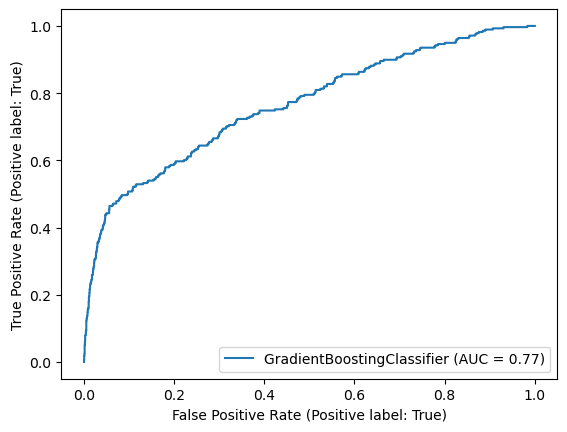

In [17]:
plot_roc_curve(best_clf, X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/assignment_1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


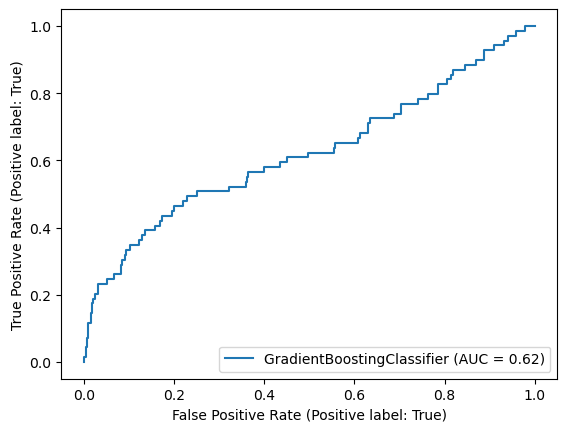

In [18]:
plot_roc_curve(best_clf, X_test, y_test)